In [1]:
# !pip3 install torch
# !pip3 install numpy
# !pip3 install matplotlib
# !pip3 install torch torchvision


In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# !pip install einops

In [4]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [5]:
import torch
result = torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "cpu"
print("Current device: " + result)
torch.cuda.empty_cache()

Current device: NVIDIA GeForce MX250


# Preparing Data

In [6]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 100
# proportion of validation set to training set
valid_size = 0.2

# convert data to torch.FloatTensor
train_tfms = transforms.ToTensor()
valid_tfms = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=train_tfms)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=valid_tfms)

# split the training dataset into training set and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# FashionMNIST Dataset

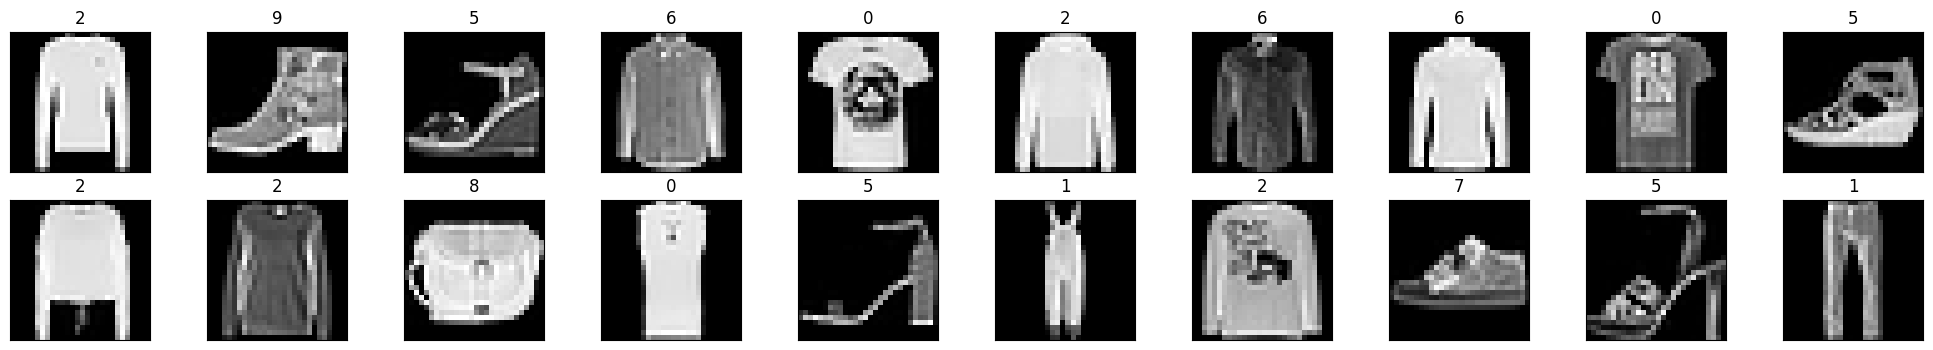

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Model Architecture

In [41]:
def to_patch(img, patch_size):
      B, C, H, W = img.shape
      sub_num = H // patch_size
      x = torch.zeros((B, sub_num ** 2, patch_size ** 2)) #patch_size default 4
      for i in range(sub_num):
        for j in range(sub_num):
          x[:, i*sub_num+j, :] = img[:, :, patch_size*i: patch_size*(i+1), patch_size*j: patch_size*(j+1)].reshape((B,patch_size ** 2))

      return x.to(device)

class Norm(nn.Module):
  """
  Layer normalization before multi-head attention block and mlp block in transformer encoder
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, dim):
    super().__init__()
    self.norm = nn.LayerNorm(dim)

  def forward(self, x):
    return self.norm(x)

class MLP(nn.Module):
  """
  Mutilayer perceptron (MLP) or Feed-forward network (FFN) block in transformer encoder
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, dim, MLP_exp_ratio):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(dim, dim * MLP_exp_ratio),
        nn.ReLU(),
        nn.Linear(dim * MLP_exp_ratio, dim)
    )

  def forward(self, x):
    return self.mlp(x)

class Multi_Head_Attention(nn.Module):
  """
  Muti-head attention block in transformer encoder
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  Muti-head attention architecure by: Attention Is All You Need
  https://arxiv.org/abs/1706.03762
  """
  def __init__(self, dim, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.dim = dim
    self.head_dim = dim // num_heads

    assert self.head_dim * num_heads == dim, "Embedding dim must divisible by nunm_heads"

    self.qkv = nn.Linear(dim, dim * 3)
    self.fc_out = nn.Linear(dim, dim)

  def forward(self, x):
    """
    Parameters of shape comments:
    B  batch size
    H  image height
    W  image width
    PH patch height
    PW patch width
    D  dimension
    HD number of heads
    DH dimension each head
    """
    B, N, D = x.shape # (B, N, D) = (100, 50, 64), N = (H/PH)*(W/PW)+1
    
    # Generate query, key and value (multiply by matrix Wq, Wk, Wv) by passing through an nn.Linear layer (learning) and split into Q, K, V 3 chunks
    qkv = self.qkv(x).reshape(B, N, 3, self.dim) # (B, (H/PH)*(W/PW)+1, 3, D) = (100, 50, 3, 64)
    qkv = qkv.permute(2, 0, 1, 3)  # (3, B, (H/PH)*(W/PW)+1, D) = (3, 100, 50, 64)
    Q, K, V = qkv[0], qkv[1], qkv[2]  # (3, B, (H/PH)*(W/PW)+1, D) -> (B, (H/PH)*(W/PW)+1, D) * 3 = (100, 50, 64) * 3

    # Split Q, K, V into num_head heads (e.g. num_head=4, dim=64)
    # (0-15 1st head, 16-31 2nd head, 32-47 3rd head, 48-63 4th head)
    Q = Q.reshape(B, self.num_heads, N, self.head_dim)  # (B, (H/PH)*(W/PW)+1, D) -> (B, HD, (H/PH)*(W/PW)+1, DH) = (100, 4, 50, 16)
    K = K.reshape(B, self.num_heads, N, self.head_dim)  # (B, (H/PH)*(W/PW)+1, D) -> (B, HD, (H/PH)*(W/PW)+1, DH) = (100, 4, 50, 16)
    V = V.reshape(B, self.num_heads, N, self.head_dim)  # (B, (H/PH)*(W/PW)+1, D) -> (B, HD, (H/PH)*(W/PW)+1, DH) = (100, 4, 50, 16)

    # Calculate attention score alpha = Q * K^T / sqrt(dk)
    attn = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5) # (B, HD, (H/PH)*(W/PW)+1, (H/PH)*(W/PW)+1) = (100, 4, 50, 50)

    # Calculate attention matrix attention = softmax(alpha)
    attn = attn.softmax(dim=-1)                          # (B, HD, (H/PH)*(W/PW)+1, (H/PH)*(W/PW)+1) = (100, 4, 50, 50)

    # Calculate output out = attention * V
    out = attn @ V                                       # (B, HD, (H/PH)*(W/PW)+1, DH) = (100, 4, 50, 16)

    # Concatenate all the heads
    out = out.transpose(1, 2).reshape(B, N, D)           # (B, HD, (H/PH)*(W/PW)+1, DH) -> (B, (H/PH)*(W/PW)+1, D) = (100, 50, 64)

    # Multiply by matrix Wo by passing through an nn.Linear layer (learning)
    out = self.fc_out(out)                                # (B, (H/PH)*(W/PW)+1, D) = (100, 50, 64)

    return out

class Transformer_Encoder(nn.Module):
  """
  Transformer encoder in ViT model
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, dim, num_heads, MLP_exp_ratio):
    super().__init__()
    self.norm1 = Norm(dim)
    self.mha = Multi_Head_Attention(dim, num_heads)
    self.norm2 = Norm(dim)
    self.mlp = MLP(dim, MLP_exp_ratio)

  def forward(self, x):
    x = x + self.mha(self.norm1(x)) # (B, (H/PH)*(W/PW)+1, D) = (100, 50, 64)
    x = x + self.mlp(self.norm2(x)) # (B, (H/PH)*(W/PW)+1, D) = (100, 50, 64)
    return x

class ViT(nn.Module):
  """
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, image_size, patch_size, dim, num_heads, num_classes, depth, MLP_exp_ratio):
    super().__init__()

    self.image_to_patch = to_patch
    #self
    self.patch_size = patch_size
    self.patch_embedding = nn.Linear(patch_size * patch_size * 1, dim)
    self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
    self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2 + 1, dim))

    self.transformer_encoders = nn.ModuleList([Transformer_Encoder(dim, num_heads, MLP_exp_ratio) for _ in range(depth)])

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, num_classes)
    )
    
  def forward(self, x): # x = (B, C, H, W) = (100, 1, 28, 28)
    # Transform image into patches
    x = self.image_to_patch(x, self.patch_size) # (B, C, H, W) -> (B, (H/PH)*(W/PW), PH*PW*C) = (100, 49, 16)

    # Patch embedding
    x = self.patch_embedding(x)               # (B, (H/PH)*(W/PW), PH*PW*C) -> (B, (H/PH)*(W/PW), D) = (100, 49, 64)

    # Class tokens
    B, N, D = x.shape
    cls_tokens = self.cls_token.expand(B, -1, -1) # (B, 1, D) = (100, 1, 64)

    # Conatenate class tokens to embedded patches
    x = torch.cat((cls_tokens, x), dim=1)     # (B, (H/PH)*(W/PW), D) -> (B, (H/PH)*(W/PW)+1, D) = (100, 50, 64)

    # Position embedding
    x = x + self.pos_embedding                # (B, (H/PH)*(W/PW)+1, D) = (100, 50, 64) shape unchanged, element-wise addition

    # Transfomer encoders with depth layers
    for encoder in self.transformer_encoders:
      x = encoder(x)                          # (B, (H/PH)*(W/PW)+1, D) = (100, 50, 64) shape unchanged

    # Take the class token for classification
    x = x[:, 0]                               # (B, (H/PH)*(W/PW)+1, D) -> (B, D) = (100, 64)

    # MLP Head block for classification
    x = self.mlp_head(x)                      # (B, D) -> (B, CLS) = (100, 10)

    return x

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT(image_size=28, patch_size=4, dim=64, num_heads=4, num_classes=10, depth=4, MLP_exp_ratio=4).to(device)

print(model)

ViT(
  (patch_embedding): Linear(in_features=16, out_features=64, bias=True)
  (transformer_encoders): ModuleList(
    (0-3): 4 x Transformer_Encoder(
      (norm1): Norm(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (mha): Multi_Head_Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (fc_out): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm2): Norm(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
        )
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
)


# Hyperparameters

In [10]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# number of epochs to train the model
n_epochs = 10

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# specify leaning rate scheduler (optional)
scheduler = scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = (len(train_loader.dataset) / batch_size) * n_epochs, eta_min = 0.00001)
print((len(train_sampler) / batch_size) * 10)

4800.0


# Training and Validation

In [11]:
from tqdm import tqdm

In [12]:
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
# initialize history for recording what we want to know
history = []

for epoch in range(n_epochs):
    # monitor training loss, validation loss and learning rate
    train_loss = 0.0
    valid_loss = 0.0
    lrs    = []
    result = {'train_loss': [], 'val_loss': [], 'lrs': []}

    # prepare model for training
    model.train()

    #######################
    # train the model #
    #######################
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        scheduler.step()

        # record learning rate
        lrs.append(optimizer.param_groups[0]['lr'])

        # update running training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################

    model.eval()
    for data,target in valid_loader:
        data, target = data.to(device), target.to(device)
        # compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,target)
        # update running validation loss
        valid_loss += loss.item()*data.size(0)

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_sampler)
    result['train_loss'] = train_loss
    valid_loss = valid_loss/len(valid_sampler)
    result['val_loss'] = valid_loss
    leaning_rate = lrs
    result['lrs'] = leaning_rate
    history.append(result)

    print('Epoch {:2d}: Learning Rate: {:.6f} Training Loss: {:.6f} Validation Loss:{:.6f}'.format(
        epoch+1,
        leaning_rate[-1],
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased({:.6f}-->{:.6f}). Saving model ..".format(
        valid_loss_min,
        valid_loss
        ))
        torch.save(model.state_dict(),"model.pt")
        valid_loss_min = valid_loss

100%|██████████| 480/480 [00:44<00:00, 10.71it/s]


Epoch  1: Learning Rate: 0.000984 Training Loss: 0.638442 Validation Loss:0.464023
Validation loss decreased(inf-->0.464023). Saving model ..


100%|██████████| 480/480 [00:43<00:00, 10.98it/s]


Epoch  2: Learning Rate: 0.000939 Training Loss: 0.402358 Validation Loss:0.383126
Validation loss decreased(0.464023-->0.383126). Saving model ..


100%|██████████| 480/480 [00:58<00:00,  8.15it/s]


Epoch  3: Learning Rate: 0.000866 Training Loss: 0.355072 Validation Loss:0.358982
Validation loss decreased(0.383126-->0.358982). Saving model ..


100%|██████████| 480/480 [01:00<00:00,  7.91it/s]


Epoch  4: Learning Rate: 0.000770 Training Loss: 0.316362 Validation Loss:0.336704
Validation loss decreased(0.358982-->0.336704). Saving model ..


100%|██████████| 480/480 [01:05<00:00,  7.30it/s]


Epoch  5: Learning Rate: 0.000658 Training Loss: 0.288090 Validation Loss:0.316695
Validation loss decreased(0.336704-->0.316695). Saving model ..


100%|██████████| 480/480 [00:56<00:00,  8.43it/s]


Epoch  6: Learning Rate: 0.000536 Training Loss: 0.261313 Validation Loss:0.304507
Validation loss decreased(0.316695-->0.304507). Saving model ..


100%|██████████| 480/480 [01:10<00:00,  6.84it/s]


Epoch  7: Learning Rate: 0.000412 Training Loss: 0.231610 Validation Loss:0.305766


100%|██████████| 480/480 [00:59<00:00,  8.12it/s]


Epoch  8: Learning Rate: 0.000294 Training Loss: 0.200001 Validation Loss:0.305643


100%|██████████| 480/480 [01:24<00:00,  5.66it/s]


Epoch  9: Learning Rate: 0.000189 Training Loss: 0.165149 Validation Loss:0.309480


100%|██████████| 480/480 [01:02<00:00,  7.63it/s]


Epoch 10: Learning Rate: 0.000105 Training Loss: 0.132039 Validation Loss:0.327053


# Plot Learning Rate Curve

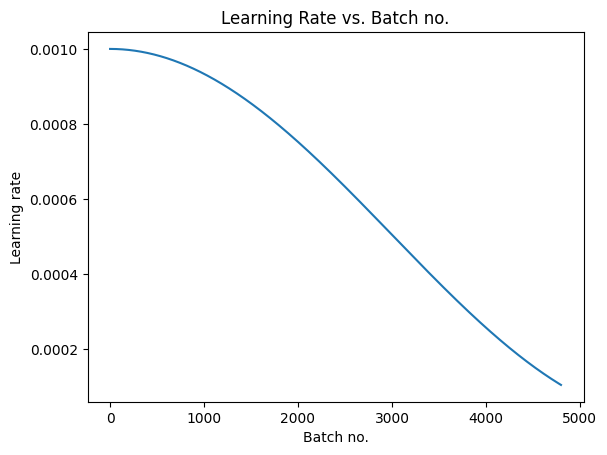

In [13]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

# Plot Loss Curve

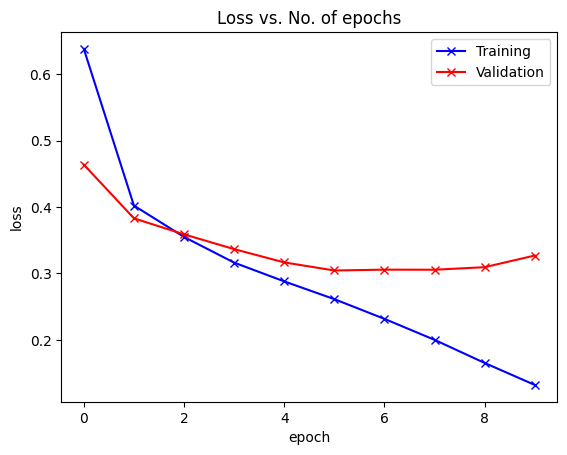

In [14]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Testing

In [16]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# prep model for evaluation
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of Class %5s: %2.2f%% (%2d/%2d)' % (
            str(i),
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i])
            ))
    else:
        print('Test Accuracy of Class %5s: N/A (no training examples)' % (str[i]))

print('\nTest Accuracy (Overall): %2.2f%% (%2d/%2d)' % (
    100 * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total)
    ))

100%|██████████| 100/100 [00:31<00:00,  3.17it/s]

Test Loss: 0.369930

Test Accuracy of Class     0: 84.70% (847/1000)
Test Accuracy of Class     1: 97.80% (978/1000)
Test Accuracy of Class     2: 76.60% (766/1000)
Test Accuracy of Class     3: 86.70% (867/1000)
Test Accuracy of Class     4: 83.20% (832/1000)
Test Accuracy of Class     5: 96.50% (965/1000)
Test Accuracy of Class     6: 68.40% (684/1000)
Test Accuracy of Class     7: 97.20% (972/1000)
Test Accuracy of Class     8: 96.40% (964/1000)
Test Accuracy of Class     9: 95.30% (953/1000)

Test Accuracy (Overall): 88.28% (8828/10000)
